-------------

# TVLA
# Test Vector Leakage Assessment methodology with the Welch's t-test
## Identifying Leakage in AES Traces

-------------




<img src='images/DoIt.png' style='width: 100px'>


The initial publication dealing with using the Welch's t test for TVLA is the following one in 2008:

<img src='./images/Welch-T-test0.png' style='width: 600px'>

https://csrc.nist.gov/csrc/media/events/non-invasive-attack-testing-workshop/documents/08_goodwill.pdf



In [2]:
import warnings
warnings.filterwarnings('ignore')

In [3]:
import numpy as np
import matplotlib.pyplot as plt
    
plt.rcParams["figure.figsize"] = [20, 5]

In [4]:
import estraces

In [5]:
ths = estraces.read_ths_from_ets_file('../SideSCA-Traces-Public/CWLite_AES_traces_100_set_random_combined_2.ets')
print(ths)

Trace Header Set:
Name.............: ETS Format THS
Reader...........: ETS format reader of file ../SideSCA-Traces-Public/CWLite_AES_traces_100_set_random_combined_2.ets with 100 traces.
ciphertext.......: uint8
key..............: uint8
plaintext........: uint8



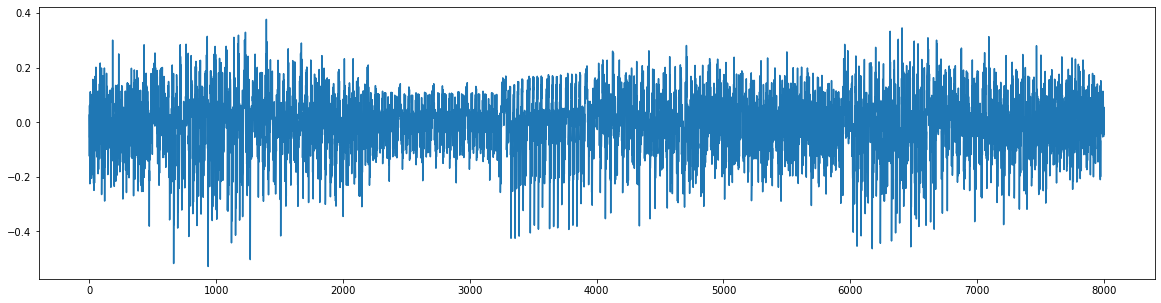

In [6]:
plt.plot(ths[0].samples)
plt.show()

----
## Use Welsh t test to detect or not leakage 

## Develop your own TVLA

In the following you will have to collect side-channel traces in order to assess if the implementation concerned seems vulnerable or not to side-channel attacks. 

At a first step you will use an open source library to detect or not leakages and then you will implement your own t-test code.

The initial publication dealing with using the Welch's t test for TVLA is the following one in 2008:

<img src='./images/Welch-T-test0.png' style='width: 600px'>

https://csrc.nist.gov/csrc/media/events/non-invasive-attack-testing-workshop/documents/08_goodwill.pdf






<img src='./images/Welch-T-test1.png' style='width: 600px'>

https://eprint.iacr.org/2017/138.pdf


---

------

### Load fixed and random input traces set

In [7]:
path_fixed = "../SideSCA-Traces-Public/CWLite_AES_traces_100_set_Fixed.ets"
path_random = "../SideSCA-Traces-Public/CWLite_AES_traces_100_set_random_combined_2.ets"

In [8]:
ths_fixed = estraces.read_ths_from_ets_file(path_fixed)
ths_random = estraces.read_ths_from_ets_file(path_random)

### Plot traces

In [9]:
import matplotlib.pyplot as plt

In [10]:
plt.rcParams['figure.figsize']=(15,3)

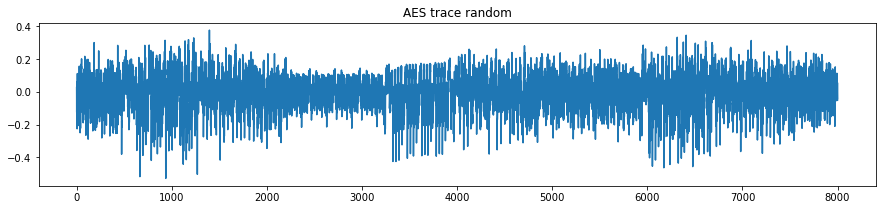

In [11]:
plt.plot(ths_random.samples[0:1].T)
plt.title('AES trace random')
plt.show()

In [12]:
def TVLA_t_test(traces_set_1, traces_set_2):

    E1 = np.mean(traces_set_1, axis = 0)
    E2 = np.mean(traces_set_2, axis = 0)
    V1 = np.var(traces_set_1, axis = 0)
    V2 = np.var(traces_set_2, axis = 0)

    t_test_trace = np.divide( (E1 - E2), ( np.sqrt((V1/len(traces_set_1)) + (V2/len(traces_set_2)))))
    
    return t_test_trace

In [13]:
t_test_result = TVLA_t_test(ths_fixed.samples, ths_random.samples)
np.shape(t_test_result)

(8000,)

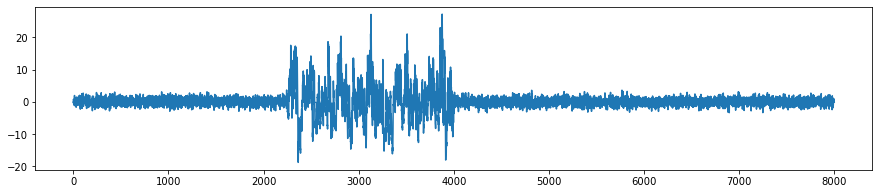

In [14]:
plt.plot(t_test_result)
plt.show()

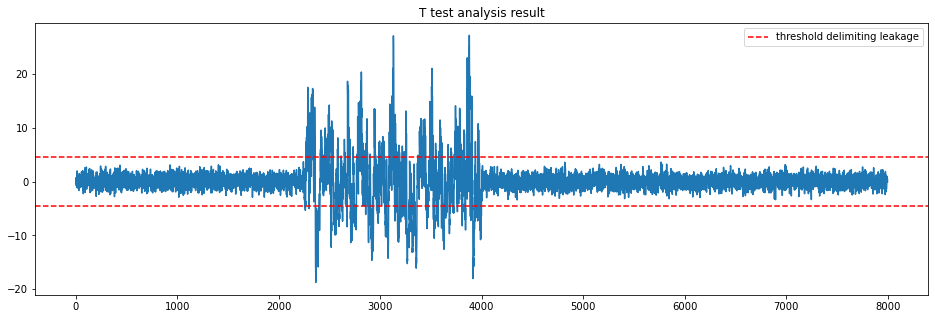

In [15]:
plt.rcParams['figure.figsize']=(16,5)
plt.plot(t_test_result)
plt.axhline(y=4.5, color='red', linestyle='--', label='threshold delimiting leakage')
plt.axhline(y=-4.5, color='red', linestyle='--')
plt.title('T test analysis result')
plt.legend(loc='upper right')
plt.show()

### Using scared 
#### Set the container and the T test

In [16]:
import scared

In [17]:
container = scared.TTestContainer(ths_1=ths_fixed, ths_2=ths_random) 

In [18]:
ttest = scared.TTestAnalysis() 

Run the T test

In [19]:
ttest.run(container) 

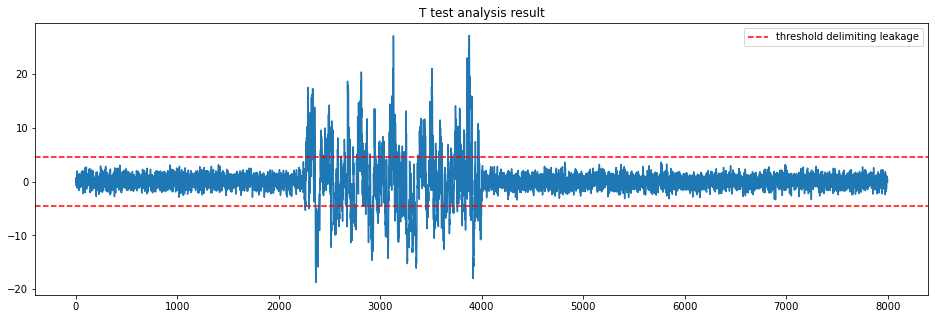

In [20]:
plt.rcParams['figure.figsize']=(16,5)
plt.plot(ttest.result)
plt.axhline(y=4.5, color='red', linestyle='--', label='threshold delimiting leakage')
plt.axhline(y=-4.5, color='red', linestyle='--')
plt.title('T test analysis result')
plt.legend(loc='upper right')
plt.show()

----
## Reverse on intermediate values

## FIND THE LEAKAGE


In [21]:
import scared

In [22]:
def aes_function_firstRde_AddKey(plaintext, key):
    return scared.aes.encrypt(plaintext = plaintext, key = key, at_round=0, after_step=scared.aes.base.Steps.ADD_ROUND_KEY)

def aes_function_firstRde_SBout(plaintext, key):
    return scared.aes.encrypt(plaintext = plaintext, key = key, at_round=1, after_step=scared.aes.base.Steps.SUB_BYTES)

def aes_function_firstRde_ShiftRow(plaintext, key):
    return scared.aes.encrypt(plaintext = plaintext, key = key, at_round=1, after_step=scared.aes.base.Steps.SHIFT_ROWS)

def aes_function_firstRde_MixColumn(plaintext, key):
    return scared.aes.encrypt(plaintext = plaintext, key = key, at_round=1, after_step=scared.aes.base.Steps.MIX_COLUMNS)

In [23]:
container = scared.Container(ths)

In [24]:
Selection_function_SB = scared.reverse_selection_function(aes_function_firstRde_SBout)
Selection_function_ADD = scared.reverse_selection_function(aes_function_firstRde_AddKey)
Selection_function_MXC = scared.reverse_selection_function(aes_function_firstRde_MixColumn)

In [25]:
Reverse_SB = scared.CPAReverse(selection_function = Selection_function_SB, model = scared.HammingWeight())
Reverse_SB.run(container)
Reverse_ADD = scared.CPAReverse(selection_function = Selection_function_ADD, model = scared.HammingWeight())
Reverse_ADD.run(container)
Reverse_MXC = scared.CPAReverse(selection_function = Selection_function_MXC, model = scared.HammingWeight())
Reverse_MXC.run(container)

In [26]:
Reverse_MXC.results.shape

(16, 8000)

### Plot results

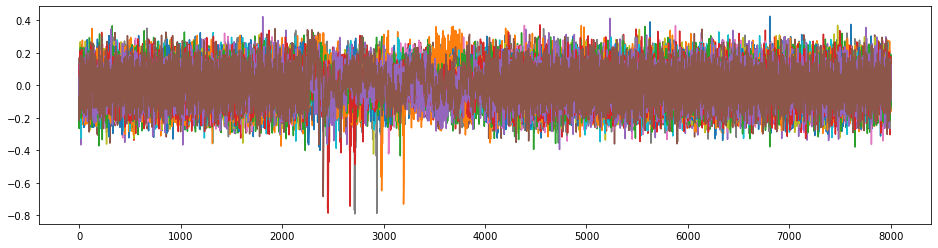

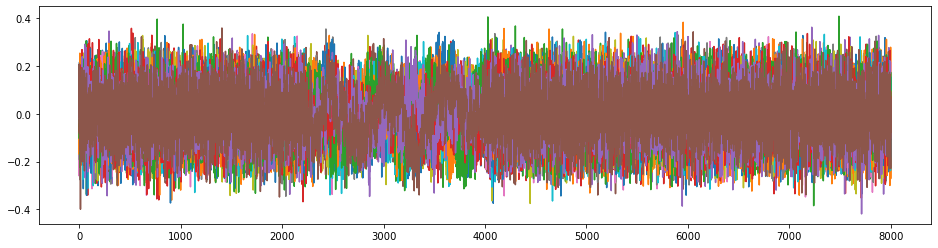

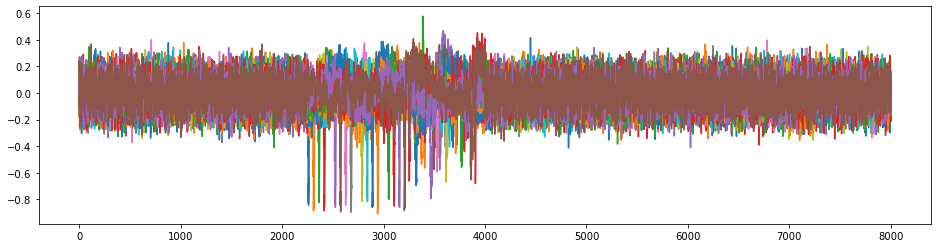

In [27]:
plt.rcParams['figure.figsize']=(16,4)
plt.plot(Reverse_SB.results.T)
plt.show()
plt.plot(Reverse_ADD.results.T)
plt.show()
plt.plot(Reverse_MXC.results.T)
plt.show()

----
## ATTACK for KEY RECOVERY




In [28]:
attack_cpa = scared.CPAAttack(
        selection_function=scared.aes.selection_functions.encrypt.FirstSubBytes(),
        model=scared.HammingWeight(),
        discriminant=scared.maxabs,
        convergence_step=len(ths)//5    
    )

In [29]:
attack_cpa.run(container)

In [30]:
attack_cpa.results.shape

(256, 16, 8000)

In [31]:
found_key = attack_cpa.scores.argmax(0).squeeze()

In [32]:
vhex = np.vectorize(hex)
print("the key found is:   ", vhex(found_key))
print("the correct key is: ", vhex(ths[0].key))

the key found is:    ['0xa9' '0xd7' '0xff' '0x16' '0x8d' '0x76' '0x3f' '0xa6' '0x11' '0x71'
 '0x8a' '0x88' '0x66' '0xcf' '0xee' '0x3c']
the correct key is:  ['0x2b' '0x7e' '0x15' '0x16' '0x28' '0xae' '0xd2' '0xa6' '0xab' '0xf7'
 '0x15' '0x88' '0x9' '0xcf' '0x4f' '0x3c']


In [33]:
attack_cpa.scores.shape

(256, 16)

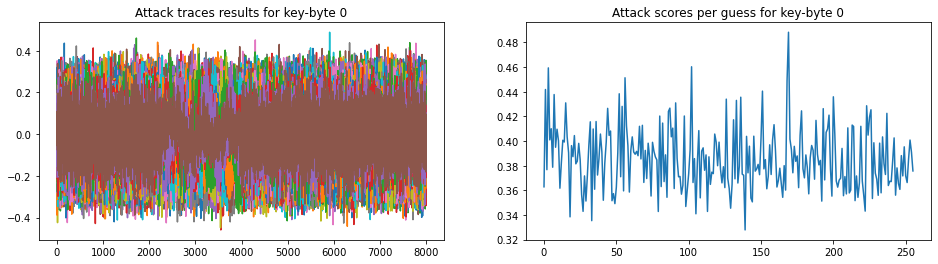

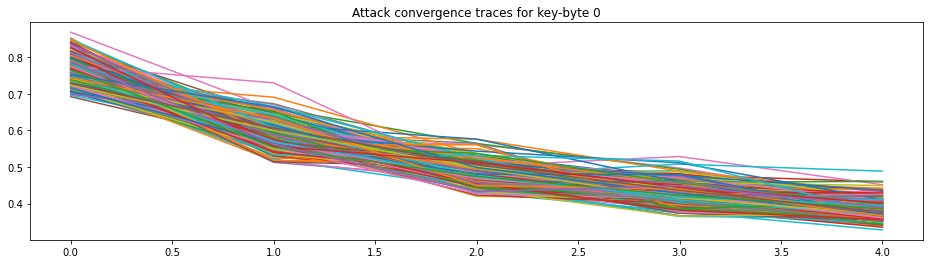

In [34]:
key_byte = 0
plt.subplot(1,2,1)
plt.title('Attack traces results for key-byte '+str(key_byte))
plt.plot(attack_cpa.results.T[:,key_byte,:])
plt.subplot(1,2,2)
plt.title('Attack scores per guess for key-byte '+str(key_byte))
plt.plot(attack_cpa.scores[:,key_byte])
plt.show()
plt.title('Attack convergence traces for key-byte '+str(key_byte))
plt.plot(attack_cpa.convergence_traces.T[:,key_byte, :])
plt.show()

----
## ATTACK for KEY RECOVERY USING CHOSEN MESSAGES 

----------




<img src='./images/chosen_mess_AES.png' style='width: 900px'>


In [64]:
ths = estraces.read_ths_from_ets_file('../SideSCA-Traces-Public/CWLite_AES_traces_chosen_512_set_2B.ets')
print(ths)

Trace Header Set:
Name.............: ETS Format THS
Reader...........: ETS format reader of file ../SideSCA-Traces-Public/CWLite_AES_traces_chosen_512_set_2B.ets with 512 traces.
ciphertext.......: uint8
key..............: uint8
plaintext........: uint8



In [65]:
ths[0:512].plaintext

array([[  0,   0,   0, ...,   0,   0,   0],
       [  1,   0,   0, ...,   0,   0,   0],
       [  2,   0,   0, ...,   0,   0,   0],
       ...,
       [  0, 253,   0, ...,   0,   0,   0],
       [  0, 254,   0, ...,   0,   0,   0],
       [  0, 255,   0, ...,   0,   0,   0]], dtype=uint8)

In [66]:
container = scared.Container(ths[0:256])

In [67]:
attack_cpa = scared.CPAAttack(
        selection_function=scared.aes.selection_functions.encrypt.FirstSubBytes(),
        model=scared.Monobit(0),
        discriminant=scared.maxabs,
        convergence_step=len(ths)//5    
    )

In [68]:
attack_cpa.run(container)

In [69]:
attack_cpa.results.shape

(256, 16, 8000)

In [70]:
found_key = attack_cpa.scores.argmax(0).squeeze()

In [71]:
vhex = np.vectorize(hex)
print("the key found is:   ", vhex(found_key))
print("the correct key is: ", vhex(ths[0].key))

the key found is:    ['0x6d' '0x0' '0x0' '0x0' '0x0' '0x0' '0x0' '0x0' '0x0' '0x0' '0x0' '0x0'
 '0x0' '0x0' '0x0' '0x0']
the correct key is:  ['0x6d' '0xb' '0x5d' '0x3b' '0xa5' '0x79' '0x48' '0xef' '0x4f' '0x6c'
 '0xcc' '0xa2' '0x11' '0x48' '0xd4' '0xd']


In [72]:
attack_cpa.scores.shape

(256, 16)

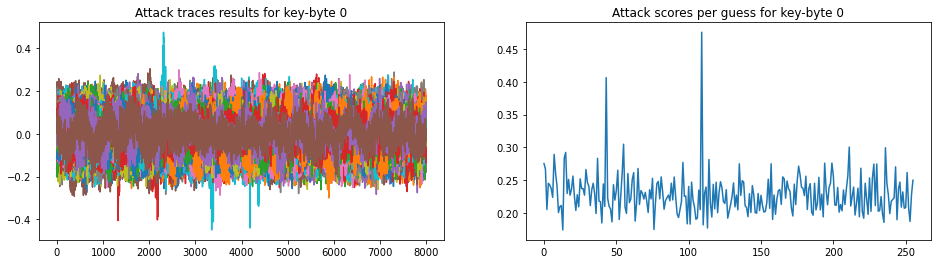

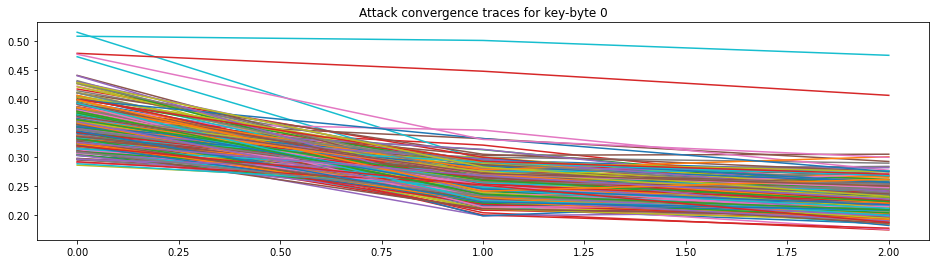

In [73]:
key_byte = 0
plt.subplot(1,2,1)
plt.title('Attack traces results for key-byte '+str(key_byte))
plt.plot(attack_cpa.results.T[:,key_byte,:])
plt.subplot(1,2,2)
plt.title('Attack scores per guess for key-byte '+str(key_byte))
plt.plot(attack_cpa.scores[:,key_byte])
plt.show()
plt.title('Attack convergence traces for key-byte '+str(key_byte))
plt.plot(attack_cpa.convergence_traces.T[:,key_byte, :])
plt.show()